# Module 4: Neural Networks

* At the end of module 2, you implemented a basic neural net with one unit. In this module, we explain what a full neural net is and how to implement it in Tensorflow 2.0

## A Neuron

* An artificial neuron is a mathematical function that computes a weighted sum of its inputs and then applies some transformation to that sum. That transformation is known as the activation function.

![alt text](neuron.png)

* In Module 2, the transformation was a `cos()` function, but that is rarely used in neural nets. The Figure above shows some common transformations.

* Neural networks get their representational power from _nonlinear_ transformations, such as $tanh$ and $relu$ above.

In [5]:
import numpy as np 

# simulate a n euron with two inputs

# input 1
x1 = 1.0

# input 2
x2 = -2.0

# weight on input 1
w1 = 0.3

# weight on input 2
w2 = 1

# bias, offset, intercept
b = 0

# weighted sum of inputs
wsum = b + w1 * x1 + w2 * x2

# nonlinear transform
neuron_output = np.tanh(wsum)

print(neuron_output)

-0.935409070603099


* The bias is important because it captures the "average" tred (remember the null model? that is an average model)
* Let's generalize the code a little bit by using vectorized operations

In [6]:
# input is now supplied as a vector of length 2
x = np.array([1.0, -2.0])

# weights are also expressed as a vector
w = np.array([0.3, 1.0])

wsum = b + np.sum(x * w)
neuron_output = np.tanh(wsum)

print(neuron_output)

-0.935409070603099


* We'll now plot the output of the neuron for many inputs
* The purpose of this exercise is to see what kind of functions a single `tanh()` neuron can learn
* Rather than using a for loop to iterate over each input, here we show how to use vectorized operations to efficiently compute the output of the neuron for all inputs

[-3.         -2.93939394 -2.87878788 ...  2.87878788  2.93939394
  3.        ]
[-3. -3. -3. ...  3.  3.  3.]


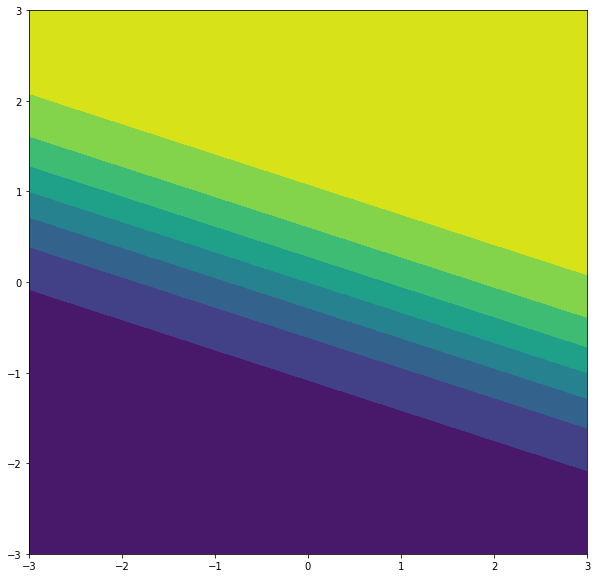

In [7]:
import matplotlib.pyplot as plt 

# initialize range of input values
K = 100
xs = np.linspace(-3, 3, K)
x1s, x2s = np.meshgrid(xs, xs)

# zip the inputs up into a (K*K, 2) array
print(x1s.flatten())
print(x2s.flatten())
X = np.vstack((x1s.flatten(), x2s.flatten())).T

# apply neuron
w = np.array([0.3, 0.9])

# for each input x_i, compute the dot product between
# x_i and w (this is the weighted sum) 
# since inputs are rows, we need to sum across the columns,
# hence axis=1
wsum = b + np.sum(X * w, axis=1) # wsum is now (K*K,)
outputs = np.tanh(wsum)

Z = np.reshape(outputs, (K, K))

f, ax = plt.subplots(1, 1, figsize=(10, 10))
cp = ax.contourf(x1s, x2s, Z)

## Multiple Neurons

* Neural nets really flex their muscles when they have multiple neurons.
* A typical NN architecture consists of input features, a hidden layer with multiple neurons, and an output layer,  as shown below

![alt text](neuralnet.png)

Let's implement a neural network with multiple neurons in the hidden layer.

(10000, 5)
(10000, 1)


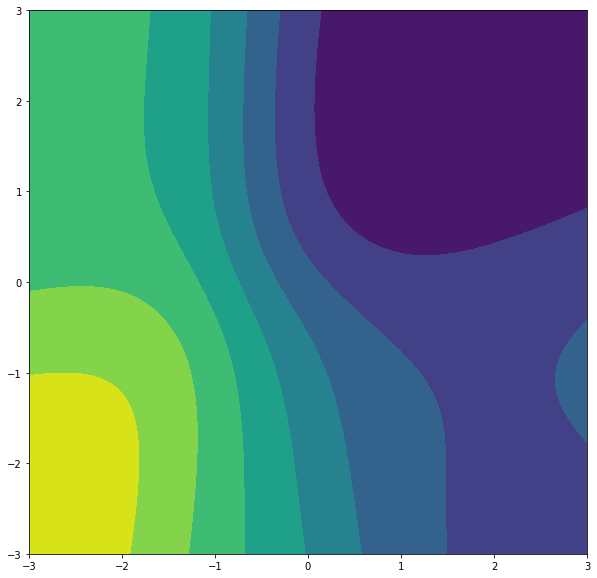

In [8]:
import numpy.random as rng 

# try varying the number of hidden units and see what happens
n_hidden = 5

# weight matrix from inputs to hidden neurons
W_input_hidden = rng.randn(2, n_hidden)

# bias of the hidden neurons
b_hidden = rng.randn(n_hidden)

# weight matrix from hidden neurons to output
W_hidden_output = rng.randn(n_hidden, 1)

# bias of the output neuron
b_output = rng.randn()

# compute hidden activation
u = np.tanh(b_hidden + np.dot(X, W_input_hidden))
print(u.shape)

# compute output
y = b_output + np.dot(u, W_hidden_output)
print(y.shape)

# plot
Z = np.reshape(y, (K, K))
f, ax = plt.subplots(1, 1, figsize=(10, 10))
cp = ax.contourf(x1s, x2s, Z)

* We see that as you increase the number of hidden units, the complexity of the functions that the network can learn increases

## Learning

* We now demonstrate how to apply a neural network to our fake datasest.
* We will use Tensorflow to do gradient descent (thankfully!)

Final MSE: 1.3341


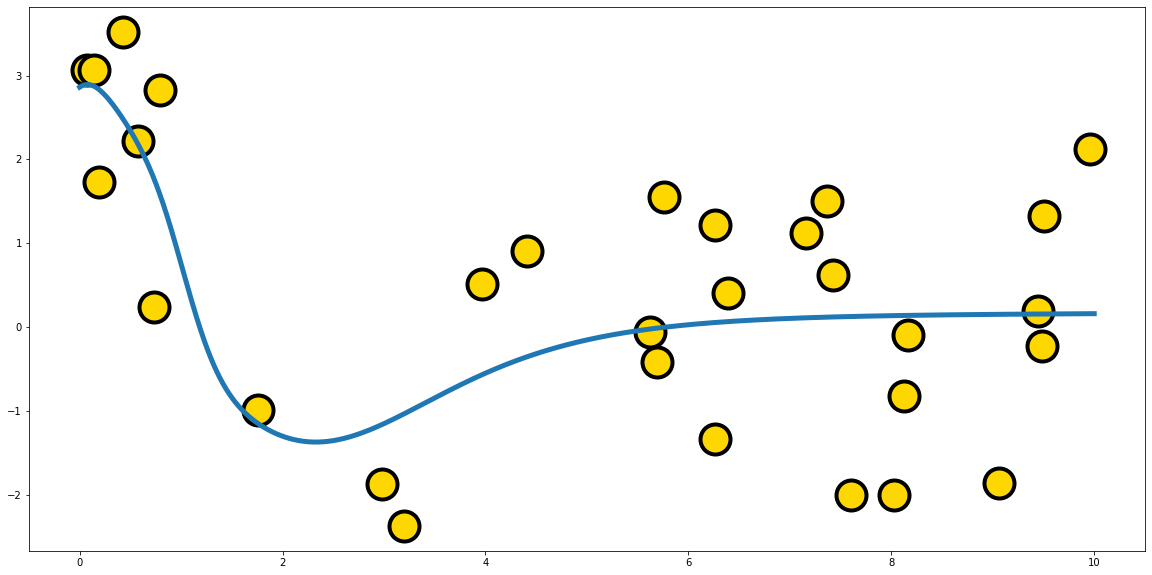

In [19]:
import numpy.random as rng 
import tensorflow as tf

# try varying the number of hidden units and learning rates
n_hidden = 100
eta = 0.01

# read data
data = np.load('code/day2/fake_data.npz')
X, y = data['X'], data['y']

# move data to tensorflow space
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]
# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 200
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
        ypred = b_output + tf.matmul(hidden_activation, W_hidden_output)
        
        # loss
        mse_loss = tf.reduce_mean(tf.square(ypred - y))
        
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(mse_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))
    
# report results
hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
ypred = b_output + tf.matmul(hidden_activation, W_hidden_output)      
mse_loss = tf.reduce_mean(tf.square(ypred - y))
print("Final MSE: %0.4f" % mse_loss.numpy())


# plot resulting function
xstar = np.linspace(0, 10, 1000)[:,np.newaxis]

xstar_tf = tf.convert_to_tensor(xstar, dtype=tf.float32)
hidden_activation = tf.tanh(b_hidden + tf.matmul(xstar_tf, W_input_hidden))
ypred = b_output + tf.matmul(hidden_activation, W_hidden_output)     

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(data['X'], data['y'], 'o', color='gold', markersize=30, 
        markeredgewidth=4, markeredgecolor='black')
ax.plot(xstar, ypred.numpy(), linewidth=5)
